In [1]:
from pymongo import MongoClient, IndexModel
import pymongo
import pandas as pd
import numpy as np
import datetime

We'll send querys on the fields `created_utc` (numeric) and `author` (string). To speed up the query, we need to create `pymongo.ASCENDING` and `pymong.HASHED` indexes on these fields.

In [2]:
client = MongoClient("localhost", 27017)
db = client["reddit_polarization"]

In [3]:
for subreddit in ("MensRights", "Feminism"):
    collection = db[subreddit]
    ids = list(collection.find({}, {"_id": 1}))
    for one_id in ids:
        post = collection.find_one(one_id)
        created_utc = post["created_utc"]
        date = datetime.datetime(created_utc.year, created_utc.month, created_utc.day)
        collection.update_one(one_id, {"$set": {"date": date}})

In [4]:
db["MensRights"].drop_indexes()
db["MensRights"].create_index([("created_utc", pymongo.ASCENDING)])
db["MensRights"].create_index([("author", pymongo.HASHED)])
#db["MensRights"].create_index([("date", pymongo.HASHED)])

db["Feminism"].drop_indexes()
db["Feminism"].create_index([("created_utc", pymongo.ASCENDING)])
db["Feminism"].create_index([("author", pymongo.HASHED)])
#db["Feminism"].create_index([("date", pymongo.HASHED)])

u'author_hashed'

In [5]:
low = datetime.datetime(year=2012, month=6, day=1)
high = datetime.datetime(year=2013, month=6, day=1)

In [6]:
def is_crossposted(subreddit, other, low, high):
    df = pd.DataFrame(list(db[subreddit].find({"created_utc": {"$lte": high, "$gte": low}},
                                              {"author": 1, "date": 1, "created_utc": 1, "subreddit": 1})))
    
    def func1(perdate_df, other):
        date = perdate_df["date"].iloc[0].to_pydatetime()        
        def func2(author, other, date, radius=5):
#            dates = [date + datetime.timedelta(days=d) for d in range(-radius, radius)]       
            l = date + datetime.timedelta(days=-radius)
            h = date + datetime.timedelta(days=radius)  
#            query = db[other].find_one({"author": author, "date": {"$in": dates}})
            query = db[other].find_one({"author": author, "date": {"$lte": h, "$gte": l}})
            return True if query else False

        perdate_df["is_cp"] = perdate_df["author"].map(lambda author: func2(author, other, date))

        return perdate_df[["author", "is_cp"]].values
    
    author_groupby_day = df.groupby("date").apply(lambda perdate_df: func1(perdate_df, other))
    return author_groupby_day

In [7]:
men_is_cp = is_crossposted("MensRights", "Feminism", low, high)
men_is_cp = men_is_cp.map(dict)
men_is_cp = dict(zip(men_is_cp.index.map(lambda date: date.to_pydatetime()), men_is_cp.values))

In [8]:
fem_is_cp = is_crossposted("Feminism", "MensRights", low, high)
fem_is_cp = fem_is_cp.map(dict)
fem_is_cp = dict(zip(fem_is_cp.index.map(lambda date: date.to_pydatetime()), fem_is_cp.values))

In [9]:
def get_data(subreddit, low, high):
    query = db[subreddit].find({"created_utc": {"$lte": high, "$gte": low}},
                               {"author": 1, "date": 1, "created_utc": 1, "subreddit": 1, "tokens_njv": 1})

    df = pd.DataFrame(list(query))
    df = df.sort_values("created_utc")
    df = df.reset_index(drop=True)
    return df

In [10]:
men = get_data("MensRights", low, high)
fem = get_data("Feminism", low, high)

In [11]:
men["is_cp"] = men.apply(lambda row: men_is_cp[row["date"]][row["author"]], axis=1)
fem["is_cp"] = fem.apply(lambda row: fem_is_cp[row["date"]][row["author"]], axis=1)

In [12]:
fem.shape

(69732, 7)

In [13]:
men.shape

(569347, 7)

In [14]:
men = men[men["is_cp"]]
fem = fem[fem["is_cp"]]

In [15]:
men.shape

(53599, 7)

In [16]:
fem.shape

(17928, 7)

In [17]:
def merge_post(df):
    return " ".join(list(df["tokens_njv"]))

In [18]:
corpus_cp = pd.concat([men, fem], axis=0)
corpus_cp = corpus_cp[corpus_cp["tokens_njv"].map(len) > 0]
corpus_cp = list(corpus_cp.groupby("author").apply(merge_post))

In [19]:
def non_crossposter():
    df = pd.DataFrame()
    for subreddit in ("MensRights", "Feminism"):
        query = db[subreddit].find({}, {"author": 1, "subreddit": 1})
        df = pd.concat([df, pd.DataFrame(list(query))], axis=0)
    
    author = df.groupby("author").apply(lambda df: len(df["subreddit"].unique()))
    ncp = list(author[author == 1].index.values)
    return ncp

In [20]:
ncp = non_crossposter()

In [21]:
def post_by_ncp(ncp, low, high):
    df = pd.DataFrame()
    for subreddit in ("MensRights", "Feminism"):
        query = db[subreddit].find({"created_utc": {"$lte": high, "$gte": low}, "author": {"$in": ncp}},
                                   {"tokens_njv": 1, "subreddit": 1, "created_utc": 1, "author": 1})
    
        df = pd.concat([df, pd.DataFrame(list(query))], axis=0)
    return df    

In [22]:
corpus_ncp = post_by_ncp(ncp, low, high)
corpus_ncp = corpus_ncp[corpus_ncp["tokens_njv"].map(len) > 0]
corpus_ncp = list(corpus_ncp.groupby("author").apply(merge_post))

In [23]:
len(corpus_cp), len(corpus_ncp)

(1728, 32122)

In [24]:
cp_index = np.random.choice(len(corpus_cp), len(corpus_cp))
ncp_index = np.random.choice(len(corpus_cp), 10000)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [27]:
def train_topic_model(corpus, topics):
#    tf_vectorizer = CountVectorizer(stop_words='english', lowercase=True, max_df=0.5, min_df=10)
#    dtm_tf = tf_vectorizer.fit_transform(corpus)
    
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_df=0.9, min_df=5, max_features=5000)
    dtm_tfidf = tfidf_vectorizer.fit_transform(corpus)
    
#    lda_tf = LatentDirichletAllocation(n_topics=20, random_state=0)
#    lda_tf.fit(dtm_tf)
    lda_tfidf = LatentDirichletAllocation(n_topics=topics, random_state=0, learning_method="online")
    lda_tfidf.fit(dtm_tfidf)
    return lda_tfidf, dtm_tfidf, tfidf_vectorizer

In [28]:
K = [2, 5, 10, 20, 50, 80, 100, 150]
perplexities = []
for n_topics in K:
    print n_topics
    cp_topic = train_topic_model([corpus_cp[i] for i in cp_index], topics=n_topics)
    p1 = cp_topic[0].perplexity(cp_topic[1])
    ncp_topic = train_topic_model([corpus_ncp[i] for i in ncp_index], topics=n_topics)
    p2 = ncp_topic[0].perplexity(ncp_topic[1])
    perplexities.append([n_topics, p1, p2])

2
5
10
20
50
80
100
150


In [29]:
perplexities = np.array(perplexities)
perplexities

array([[  2.00000000e+00,   6.67934737e+03,   4.10546432e+03],
       [  5.00000000e+00,   9.49358970e+04,   5.10426125e+04],
       [  1.00000000e+01,   5.78309248e+06,   2.10250189e+06],
       [  2.00000000e+01,   1.79933159e+10,   2.67615987e+09],
       [  5.00000000e+01,   3.90249153e+20,   4.36934342e+18],
       [  8.00000000e+01,   7.37706496e+30,   7.14359833e+27],
       [  1.00000000e+02,   5.07325742e+37,   8.04288524e+33],
       [  1.50000000e+02,   6.02944936e+54,   1.39456489e+49]])

In [26]:
from gensim import corpora, models

/home/jichao/anaconda2/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


In [36]:
def train_topic_model_gensim_lda(corpus, topics):
    corpus = map(lambda text: filter(lambda word: len(word) > 0, text.split(" ")), corpus)
    dictionary = corpora.Dictionary(corpus)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf_model = models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]
    lda_model = models.ldamodel.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=topics, iterations=50)

    return lda_model, corpus_tfidf, dictionary

In [45]:
K = [2, 5, 10, 20, 50, 80, 100, 150]
tc = []
for k in K:
    print k
    model_cp = train_topic_model_gensim_lda([corpus_cp[i] for i in cp_index], k)
    model_ncp = train_topic_model_gensim_lda([corpus_ncp[i] for i in ncp_index], k)
    
    cm_cp = models.coherencemodel.CoherenceModel(model=model_cp[0],
                                                corpus=model_cp[1],
                                                dictionary=model_cp[2],
                                                coherence='u_mass')
    a = cm_cp.get_coherence()

    cm_ncp = models.coherencemodel.CoherenceModel(model=model_ncp[0],
                                                 corpus=model_ncp[1],
                                                 dictionary=model_ncp[2],
                                                 coherence='u_mass')
    b = cm_ncp.get_coherence()    
    tc.append([k, a, b])

2
5
10
20
50
80
100
150


In [47]:
tc = np.array(tc)

In [50]:
tc

array([[   2.        ,   -0.25958899,   -0.62517389],
       [   5.        ,   -0.26983207,   -0.87514263],
       [  10.        ,   -0.34380706,   -1.82248062],
       [  20.        ,   -0.32442354,   -5.23175225],
       [  50.        ,   -1.65488198,   -6.37169528],
       [  80.        ,   -4.27329987,   -6.5931684 ],
       [ 100.        ,   -5.84241997,   -7.16050468],
       [ 150.        ,   -7.23834197,   -6.92740647]])

In [25]:

from pyLDAvis import sklearn

In [63]:
data = sklearn.prepare(*fem_topic, mds="tsne")
pyLDAvis.display(data)

In [64]:
fem_topic = train_topic_model(corpus_fem_ncp)

In [65]:
data = sklearn.prepare(*fem_topic, mds="tsne")
pyLDAvis.display(data)

In [27]:
def train_topic_model_gensim_hdp(corpus):
    corpus = map(lambda text: filter(lambda word: len(word) > 0, text.split(" ")), corpus)
    dictionary = corpora.Dictionary(corpus)
    corpus_bow = [dictionary.doc2bow(doc) for doc in corpus]
    tfidf_model = models.TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]
    hdp_model = models.hdpmodel.HdpModel(corpus_tfidf, id2word=dictionary)

    return hdp_model, corpus_tfidf, dictionary

In [37]:
model_cp = train_topic_model_gensim_lda([corpus_cp[i] for i in cp_index], 30)
model_ncp = train_topic_model_gensim_lda([corpus_ncp[i] for i in ncp_index], 100)

In [29]:
import pyLDAvis
from pyLDAvis import gensim

In [38]:
data = gensim.prepare(*model_cp)
pyLDAvis.display(data)

In [39]:
data = gensim.prepare(*model_ncp)
pyLDAvis.display(data)

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

l_cp = np.array(map(lambda x: len(x.split(" ")), corpus_cp) )
l_ncp = np.array(map(lambda x: len(x.split(" ")), corpus_ncp) )

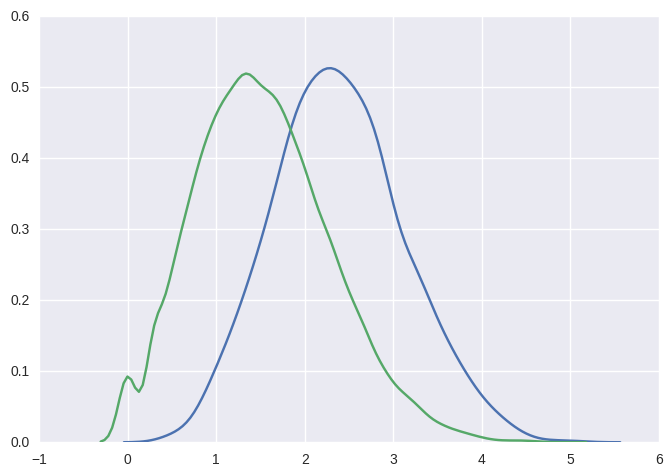

In [45]:
sns.kdeplot(np.log10(l_cp))
sns.kdeplot(np.log10(l_ncp))
plt.legend(["crossposting", "non-crossposting"])
plt.show()